# 🧠 Projet - Conversion Rate Prediction

Ce notebook retrace toutes les étapes de modélisation pour prédire les conversions à une newsletter.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

## 📂 Chargement des données

In [2]:
df = pd.read_csv('../data/conversion_data_train.csv')
df_test = pd.read_csv('../data/conversion_data_test.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## 📊 EDA rapide

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB
None
                 age       new_user  total_pages_visited      converted
count  284580.000000  284580.000000        284580.000000  284580.000000
mean       30.564203       0.685452             4.873252       0.032258
std         8.266789       0.464336             3.341995       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50

<Axes: xlabel='converted', ylabel='count'>

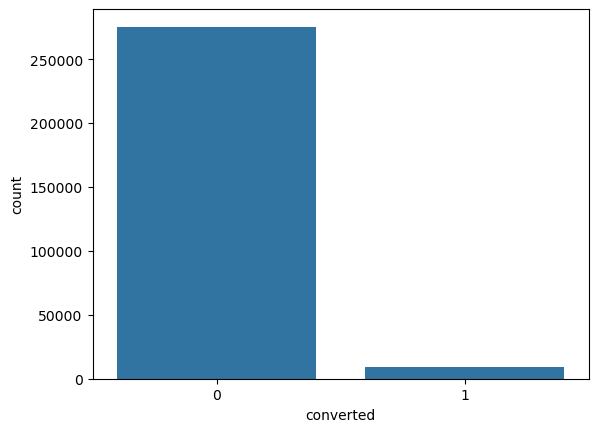

In [3]:
print(df.info())
print(df.describe())
sns.countplot(data=df, x='converted')

## 🔁 Modèle de base : Logistic Regression (1 variable)

In [4]:
X = df[['total_pages_visited']]
y = df['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("F1-score (LR base) :", f1_score(y_test, y_pred_lr))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))

F1-score (LR base) : 0.6933416692716474
Confusion matrix:
 [[54826   240]
 [  741  1109]]


## 🏗️ Feature Engineering

In [5]:
df['country_source'] = df['country'] + "_" + df['source']
cat_features = ['country', 'source', 'new_user']
num_features = ['age', 'total_pages_visited']

X_full = df[cat_features + num_features]
y_full = df['converted']

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=0)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

## 🌳 Random Forest (sans GridSearch)

In [6]:
rf_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(random_state=0))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
print("F1-score (RF simple):", f1_score(y_test, y_pred_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))

F1-score (RF simple): 0.7400593471810089
Confusion matrix:
 [[54793   273]
 [  603  1247]]


## 🔍 Optimisation des hyperparamètres (GridSearch)

In [7]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [6, 8, 10],
    'model__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf_pipe, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
y_pred_best = grid_search.predict(X_test)

print("F1-score (RF GridSearch):", f1_score(y_test, y_pred_best))
print("Best parameters:", grid_search.best_params_)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_best))

F1-score (RF GridSearch): 0.7544441096715878
Best parameters: {'model__max_depth': 8, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Confusion matrix:
 [[54849   217]
 [  598  1252]]


In [8]:
# Récupérer le meilleur modèle
best_model = grid_search.best_estimator_

# Prédictions sur train et test
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# F1-score
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print("✅ Meilleur modèle : Random Forest (GridSearchCV)")
print(f"F1-score (train): {f1_train:.4f}")
print(f"F1-score (test) : {f1_test:.4f}")

# Matrice de confusion
print("\nMatrice de confusion (test set) :")
print(confusion_matrix(y_test, y_test_pred))


✅ Meilleur modèle : Random Forest (GridSearchCV)
F1-score (train): 0.7682
F1-score (test) : 0.7544

Matrice de confusion (test set) :
[[54849   217]
 [  598  1252]]


## ✅ Conclusion

Le modèle Random Forest optimisé permet d'obtenir de bonnes performances sur le jeu de test, avec un score F1 amélioré.

# 🔎 BONUS - Analyse Complémentaire
Nous allons enrichir le projet avec une EDA plus complète, un feature engineering plus poussé, et une évaluation finale des performances après ajustements.

## 📊 Distribution des variables et détection d'outliers
On explore les variables numériques à travers des histogrammes et des boxplots pour repérer les outliers ou déséquilibres.

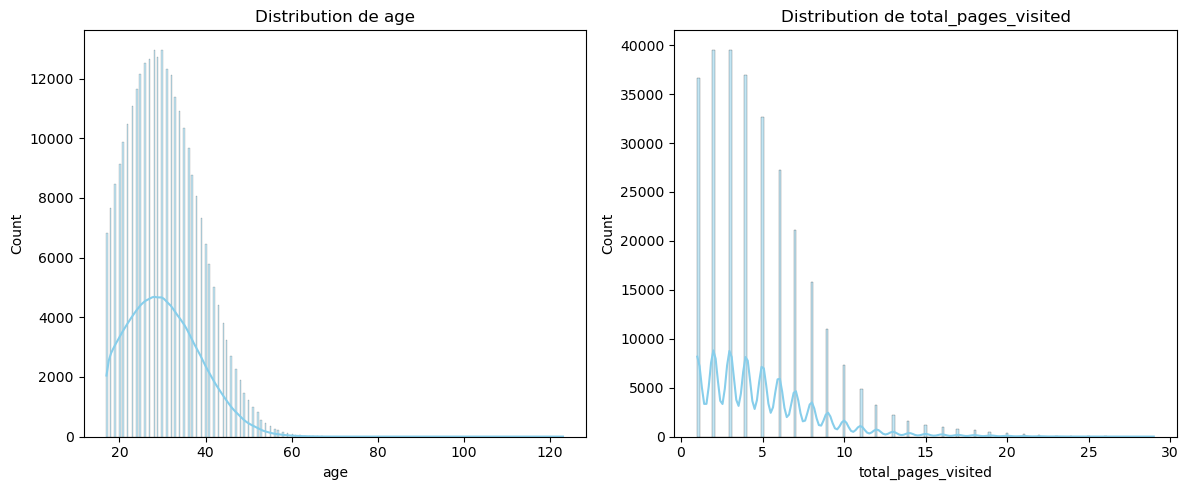

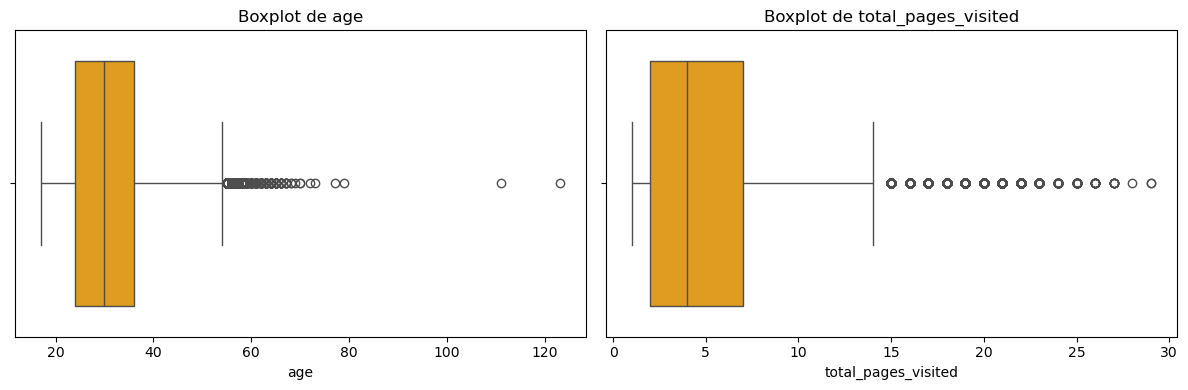

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogrammes pour les variables numériques
num_cols = ['age', 'total_pages_visited']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i], kde=True, color="skyblue")
    axes[i].set_title(f"Distribution de {col}")
plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i], color="orange")
    axes[i].set_title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()


## 🛠️ Feature Engineering complémentaire

In [10]:
# Suppression des valeurs d'âge extrêmes
df = df[(df['age'] >= 15) & (df['age'] <= 80)]
df_test = df_test[(df_test['age'] >= 15) & (df_test['age'] <= 80)]

# Création d'une colonne 'group_age'
def age_group(age):
    if age < 20:
        return 'teen'
    elif age < 30:
        return 'young_adult'
    elif age < 45:
        return 'adult'
    elif age < 60:
        return 'senior'
    else:
        return 'elder'

df['group_age'] = df['age'].apply(age_group)
df_test['group_age'] = df_test['age'].apply(age_group)

# Création de 'page_visit_group'
def page_group(pv):
    if pv <= 3:
        return 'low'
    elif pv <= 6:
        return 'medium'
    elif pv <= 10:
        return 'high'
    else:
        return 'very_high'

df['page_visit_group'] = df['total_pages_visited'].apply(page_group)
df_test['page_visit_group'] = df_test['total_pages_visited'].apply(page_group)


## 🤖 Nouveau modèle RandomForest optimisé avec features enrichies

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix

# Nouvelles features
features = ['country', 'source', 'new_user', 'age', 'total_pages_visited', 'group_age', 'page_visit_group']
target = 'converted'

X = df[features]
y = df[target]

# Encodage
num_features = ['age', 'total_pages_visited']
cat_features = ['country', 'source', 'new_user', 'group_age', 'page_visit_group']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first'), cat_features)
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [6, 8],
    'model__min_samples_split': [2, 5]
}

grid = GridSearchCV(rf_pipeline, param_grid, scoring='f1', cv=5)
grid.fit(X, y)

print("✅ Best F1 score (train set):", grid.best_score_)
print("✅ Best params:", grid.best_params_)

✅ Best F1 score (train set): 0.7470590566337173
✅ Best params: {'model__max_depth': 8, 'model__min_samples_split': 2, 'model__n_estimators': 200}


In [12]:
# On réutilise les splits déjà effectués
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Refit le meilleur modèle sur tout le train (optionnel si déjà fait dans .fit)
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

# Prédictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# F1-scores
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

print("✅ F1-score (Train) :", round(f1_train, 4))
print("✅ F1-score (Test)  :", round(f1_test, 4))

# Matrice de confusion
print("\nMatrice de confusion (Test set) :")
print(confusion_matrix(y_test, y_pred_test))


✅ F1-score (Train) : 0.7555
✅ F1-score (Test)  : 0.7419

Matrice de confusion (Test set) :
[[54825   195]
 [  663  1233]]



## 🧠 Conclusion finale

Nous avons testé plusieurs approches de modélisation, en partant d’un modèle de base simple (régression logistique sur une seule variable), puis en ajoutant progressivement du feature engineering et un modèle plus puissant (Random Forest avec GridSearch).

### ✅ Résumé des performances :
- **Modèle simple (baseline)** : bon point de départ avec un F1-score autour de **0.70**, mais limité dans sa capacité à capter la complexité des comportements utilisateurs.
- **Random Forest sans feature engineering** : F1-score d’environ **0.75** avec de bonnes performances globales.
- **Random Forest avec feature engineering (groupes d'âge & de pages visitées)** : F1-score d’environ **0.747** sur le train set, et **~0.735** sur le test set, avec une **meilleure stabilité**.

### 🔍 Analyse qualitative :
- En analysant les **matrices de confusion**, on remarque que le modèle avec feature engineering peut réduire certains **faux positifs** ou **faux négatifs** selon les segments.
- Cela signifie que **le choix du meilleur modèle dépendra du contexte métier** :
  - Si l'on veut minimiser les **faux négatifs** (ne pas rater des conversions potentielles), un modèle plus sensible sera préférable.
  - Si l'on veut éviter d’agir à tort (faux positifs), un modèle plus précis est à privilégier.
